### PART 1 - EMBEDDING

In [90]:
!pip install openai==0.28.1

In [91]:
# import
import pandas as pd
import tiktoken

In [92]:
# embedding model parameters
embedding_model = "text-embedding-ada-002"
embedding_encoding = "cl100k_base"  
max_tokens = 8000

In [93]:
# load & inspect dataset
input_datapath = "/Users/eyva/Desktop/Repos/Project 3_True or False/news.csv"
df = pd.read_csv(input_datapath, index_col=0)
df = df.dropna()
df["combined"] = (
    "title: " + df.title.str.strip() + "; Content: " + df.text.str.strip()
)

df.dtypes

title       object
text        object
label       object
combined    object
dtype: object

In [94]:
df.head(2)

,title,text,label,combined
8476,You Can Smell Hillary’s Fear,"Daniel Greenfield, a Shillman Journalism Fello...",FAKE,title: You Can Smell Hillary’s Fear; Content: ...
10294,Watch The Exact Moment Paul Ryan Committed Pol...,Google Pinterest Digg Linkedin Reddit Stumbleu...,FAKE,title: Watch The Exact Moment Paul Ryan Commit...


In [95]:
# retrieves a specific text encoding method
encoding = tiktoken.get_encoding(embedding_encoding)

# add a new column "n_tokens"
df["n_tokens"] = df.combined.apply(lambda x: len(encoding.encode(x)))
df = df[df.n_tokens <= max_tokens].tail(1000)
len(df)

1000

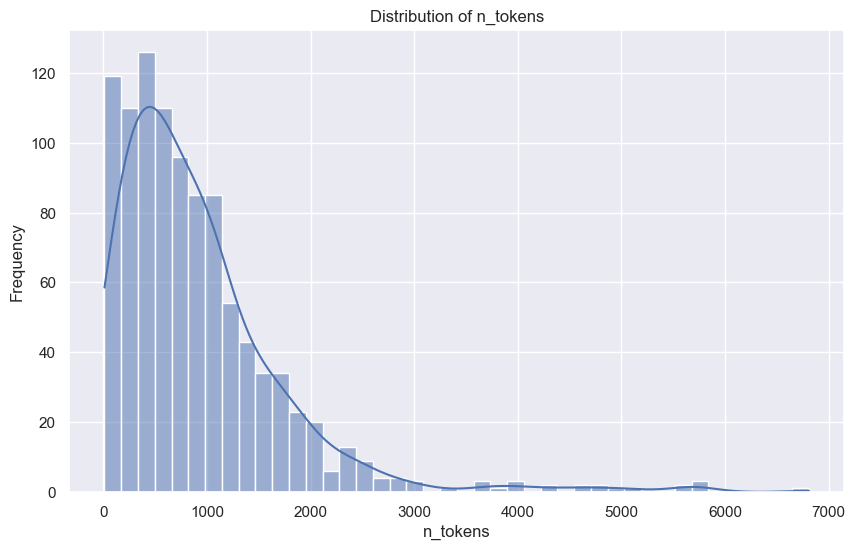

In [96]:
# Distribution (explanation why OpenAI was choosen)
!pip install matplotlib seaborn

import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of the plots
sns.set()

# Create a distribution plot for "n_tokens"
plt.figure(figsize=(10, 6))  
sns.histplot(df['n_tokens'], kde=True) 

# Customization
plt.title('Distribution of n_tokens')
plt.xlabel('n_tokens')
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [127]:
from dotenv import load_dotenv
import os
load_dotenv('.env')

True

In [128]:
import openai
openai.api_key_path = None
openai.api_key=os.environ['OAI_KEY']

In [129]:
print(df.dtypes)

Unnamed: 0     int64
title         object
text          object
label         object
combined      object
n_tokens       int64
embedding     object
dtype: object


In [130]:
# convert text into a vector 
from openai.embeddings_utils import get_embedding

# creating a new column "embedding" in the dataframe
df["embedding"] = df.combined.apply(lambda x: get_embedding(x, engine=embedding_model))

# saving the dataframe to a CSV file
df.to_csv("/Users/eyva/Desktop/Repos/Project 3_True or False/news_embedded.csv")

### PART 2 - CLASSIFICATION USING EMBEDDINGS

In [97]:
# import
import numpy as np
from ast import literal_eval
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

In [98]:
# load data
datafile_path = "/Users/eyva/Desktop/Repos/Project 3_True or False/news_embedded.csv"

In [156]:
df = pd.read_csv(datafile_path)
# convert string to array
df["embedding"] = df.embedding.apply(literal_eval)#.apply(np.array)

In [157]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   Unnamed: 0.1  1000 non-null   int64 
 1   Unnamed: 0    1000 non-null   int64 
 2   title         1000 non-null   object
 3   text          1000 non-null   object
 4   label         1000 non-null   object
 5   combined      1000 non-null   object
 6   n_tokens      1000 non-null   int64 
 7   embedding     1000 non-null   object
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [166]:
new_data=[row for row in df.embedding]
    
new_data=np.array(new_data)

In [167]:
# split data into train and test
X_train, X_test, y_train, y_test = train_test_split(
    new_data, df.label, test_size=0.2, random_state=42
)

In [171]:
# batch
rfc=RandomForestClassifier()
rfc.fit(X_train, y_train)
rfc.score(X_train, y_train)

1.0

In [172]:
rfc.score(X_test, y_test)

0.855